In [ ]:
# Install necessary libraries
!pip install tensorflow pandas numpy matplotlib scikit-learn opencv-python

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Num GPUs Available:  0


In [ ]:
import os
import shutil
from google.colab import drive
drive.mount('/content/drive')
# 1. Define Source (Drive) and Destination (Local Colab)
source_train = '/content/drive/MyDrive/cdc/images_train'
source_test = '/content/drive/MyDrive/cdc/images_test'

dest_train = '/content/images_train'
dest_test = '/content/images_test'

# 2. Copy the files
print("Copying training images to local disk... (This takes a few mins)")
if not os.path.exists(dest_train):
    shutil.copytree(source_train, dest_train)
    print("Training images copied!")
else:
    print("Training images already exist locally.")

print("Copying test images to local disk...")
if not os.path.exists(dest_test):
    shutil.copytree(source_test, dest_test)
    print("Test images copied!")
else:
    print("Test images already exist locally.")

print("Done! Data is now on fast local storage.")

Mounted at /content/drive
Copying training images to local disk... (This takes a few mins)
Training images copied!
Copying test images to local disk...
Test images copied!
Done! Data is now on fast local storage.


In [ ]:
BASE_DIR = '/content/drive/MyDrive/cdc' #for CSVs (they are small)

#The new local folders
TRAIN_IMAGES_DIR = '/content/images_train'
TEST_IMAGES_DIR = '/content/images_test'

# Load CSVs
train_csv_path = os.path.join(BASE_DIR, 'train(1)(train(1)).csv')
test_csv_path = os.path.join(BASE_DIR, 'test2(test(1)).csv')

# Load Data
df_train_full = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

# print(f"Original Training Samples: {len(df_train_full)}")
# df_train_full = df_train_full.head(100) # Keep only 100 samples
# df_test = df_test.head(20)              # Keep only 20 samples
# print("DEBUG MODE: Reduced to 100 samples for quick check.")

print(f"Training Samples: {len(df_train_full)}")
print(f"Test Samples: {len(df_test)}")

Training Samples: 16209
Test Samples: 5404


In [ ]:
# 1. Feature Engineering on Tabular Data
def preprocess_tabular(df, scaler=None, is_train=True):
    # Drop non-feature columns
    # add 'image_path' here so if re-run the cell, it doesn't crash
    cols_to_drop = ['id', 'date', 'image_path']
    if 'price' in df.columns:
        cols_to_drop.append('price')

    # Only drop columns that actually exist in the dataframe
    actual_cols_to_drop = [c for c in cols_to_drop if c in df.columns]
    X = df.drop(columns=actual_cols_to_drop)

    # Handle missing values
    X = X.fillna(0)

    # Scale data
    if is_train:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled, scaler
    else:
        X_scaled = scaler.transform(X)
        return X_scaled, None

# Prepare Tabular Data
X_tab_full, scaler = preprocess_tabular(df_train_full, is_train=True)
y_full = df_train_full['price'].values
X_tab_test, _ = preprocess_tabular(df_test, scaler=scaler, is_train=False)

# 2. Add Image Paths to DataFrames for easier loading
def get_image_path(id_col, folder):
    return folder + '/' + id_col.astype(str) + '.png'

df_train_full['image_path'] = get_image_path(df_train_full['id'], TRAIN_IMAGES_DIR)
df_test['image_path'] = get_image_path(df_test['id'], TEST_IMAGES_DIR)

print("Preprocessing complete. Image paths added.")

# 3. Custom Data Generator (load images + tabular data)
class MultiModalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, tabular_data, image_paths, labels=None, batch_size=32, img_size=(128, 128), shuffle=True, **kwargs):
        super().__init__(**kwargs) # super init to silence warning
        self.df = df
        self.tabular_data = tabular_data
        self.image_paths = image_paths.values
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Load Images
        batch_img_paths = self.image_paths[indices]
        X_img = []
        for p in batch_img_paths:
            # Check if file exists, else use black image
            if os.path.exists(p):
                img = cv2.imread(p)
                if img is None: # handle unreadable files
                     img = np.zeros((self.img_size[0], self.img_size[1], 3))
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, self.img_size)
                    img = img / 255.0 # Normalize
            else:
                img = np.zeros((self.img_size[0], self.img_size[1], 3))
            X_img.append(img)
        X_img = np.array(X_img)

        # Load Tabular
        X_tab = self.tabular_data[indices]

        #  Return a Dictionary mapping input names to data
        # This matches the names 'tabular_input' and 'image_input' in the model definition
        inputs = {"tabular_input": X_tab, "image_input": X_img}

        if self.labels is not None:
            y = self.labels[indices]
            return inputs, y
        else:
            return inputs

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Split Train/Val
X_train_tab, X_val_tab, y_train, y_val, idx_train, idx_val = train_test_split(
    X_tab_full, y_full, np.arange(len(df_train_full)), test_size=0.2, random_state=42
)

# Create Generators
train_gen = MultiModalDataGenerator(
    df_train_full.iloc[idx_train], X_train_tab, df_train_full.iloc[idx_train]['image_path'], y_train, batch_size=32
)
val_gen = MultiModalDataGenerator(
    df_train_full.iloc[idx_val], X_val_tab, df_train_full.iloc[idx_val]['image_path'], y_val, batch_size=32, shuffle=False
)

Preprocessing complete. Image paths added.


In [ ]:
def create_multimodal_model(tabular_shape, img_shape=(128, 128, 3)):
    # 1: Tabular Data
    input_tab = Input(shape=(tabular_shape,), name="tabular_input")
    x1 = layers.Dense(64, activation='relu')(input_tab)
    x1 = layers.Dense(32, activation='relu')(x1)

    # 2: Image Data (CNN)
    input_img = Input(shape=img_shape, name="image_input")

    # Using a simple custom CNN here 
    x2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_1")(input_img)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="last_conv_layer")(x2) # Named for GradCAM
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(64, activation='relu')(x2)

    # Fusion
    combined = layers.concatenate([x1, x2])

    # Final Regression Head 
    z = layers.Dense(64, activation='relu')(combined)
    z = layers.Dense(1, activation='linear', name="price_output")(z) # Linear for regression

    model = Model(inputs=[input_tab, input_img], outputs=z)
    return model

model = create_multimodal_model(tabular_shape=X_train_tab.shape[1])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 128, 128,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv_1[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_conv_layer     │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ last_conv_layer[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      1,216 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 65536)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │  4,194,368 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      6,208 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         65 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,223,329 (16.11 MB)

 Trainable params: 4,223,329 (16.11 MB)

 Non-trainable params: 0 (0.00 B)

Architecture diagram saved as model_architecture.png


In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True)
print("Architecture diagram saved as model_architecture.png")

Architecture diagram saved as model_architecture.png


Epoch 1/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 360s 880ms/step - loss: 226331475968.0000 - mae: 335135.7188 - val_loss: 127624355840.0000 - val_mae: 232590.5000
Epoch 2/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 372s 857ms/step - loss: 142092189696.0000 - mae: 233135.6875 - val_loss: 95223119872.0000 - val_mae: 198798.7188
Epoch 3/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 356s 879ms/step - loss: 81311113216.0000 - mae: 177745.8906 - val_loss: 47446626304.0000 - val_mae: 143606.9375
Epoch 4/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 356s 880ms/step - loss: 42614108160.0000 - mae: 136316.2031 - val_loss: 40286257152.0000 - val_mae: 137209.6562
Epoch 5/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 355s 878ms/step - loss: 38222512128.0000 - mae: 129045.7578 - val_loss: 37352280064.0000 - val_mae: 128751.2266
Epoch 6/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 356s 879ms/step - loss: 38869291008.0000 - mae: 125641.8047 - val_loss: 36957016064.0000 - val_mae: 124669.1797
Epoch 7/15
405/405 ━━━━━━━━━━━━━━━━━━━━ 357s 883ms/step - loss: 40998166528.0000 - ma

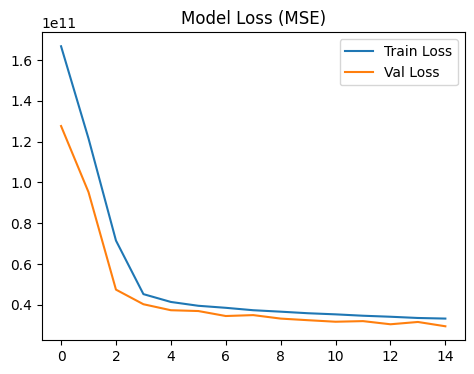

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15, 
    verbose=1
)

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


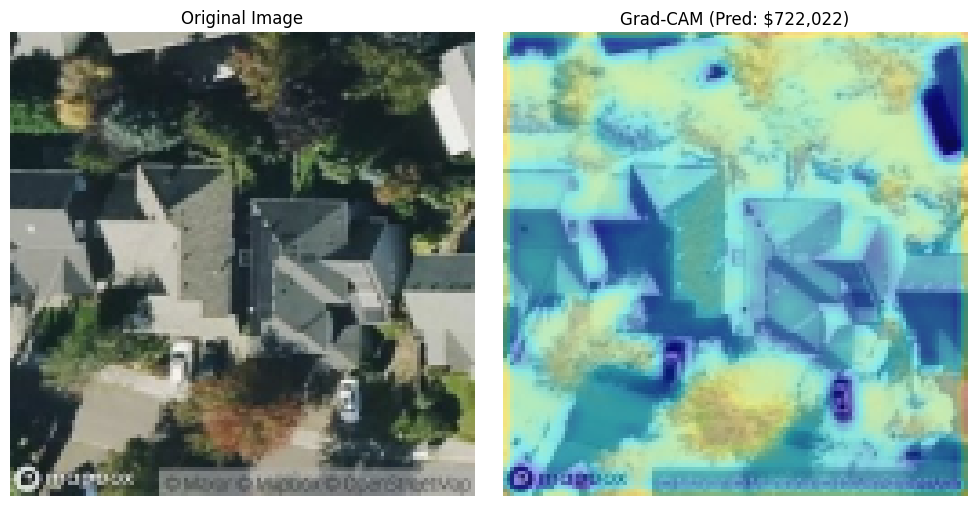

In [ ]:
# GRAD-CAM

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, tabular_data, last_conv_layer_name="last_conv_layer", pred_index=None):
    # 1. Create a model that maps the input image + tabular data to the activations of the last conv layer and the final predictions
    grad_model = Model(
        inputs=model.inputs, # Expects [Tabular, Image]
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Cast inputs to float32
        tab_input = tf.cast(tabular_data, tf.float32)
        img_input = tf.cast(img_array, tf.float32)

        # Forward pass
        # Order matches model.inputs: [tabular_input, image_input]
        (last_conv_layer_output, preds) = grad_model([tab_input, img_input])

        # For regression, we focus on the single output value
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 4. Global Average Pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Multiply each channel by its importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# EXECUTION & VISUALIZATION

# Select a sample from the VALIDATION set to visualize
sample_idx = 0 

# 1. Get the Image Path
# We use idx_val to map back to the original dataframe row
sample_img_path = df_train_full.iloc[idx_val[sample_idx]]['image_path']

# 2. Get the Tabular Data
# X_val_tab is a numpy array, so we use standard slicing [start:stop]
real_tabular_row = X_val_tab[sample_idx:sample_idx+1]

if os.path.exists(sample_img_path):
    # Load and preprocess the image
    img = cv2.imread(sample_img_path)
    if img is None:
        print(f"Error reading image: {sample_img_path}")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (128, 128))
        img_normalized = img_resized / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)

        # Generate Heatmap
        heatmap = make_gradcam_heatmap(
            img_batch,
            model,
            real_tabular_row,  # Passing the tabular data
            last_conv_layer_name="last_conv_layer"
        )

        # Plotting
        plt.figure(figsize=(10, 5))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(img_resized)
        plt.title(f"Original Image")
        plt.axis('off')

        # Heatmap Overlay
        plt.subplot(1, 2, 2)
        # Resize heatmap to match image dimensions
        heatmap_resized = cv2.resize(heatmap, (128, 128))
        # Convert to 0-255 range
        heatmap_uint8 = np.uint8(255 * heatmap_resized)
        # Apply standard heatmap color map (Jet)
        heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

        # Superimpose (0.4 is transparency intensity)
        superimposed_img = heatmap_colored * 0.4 + (img_resized * 255) * 0.6

        plt.imshow(superimposed_img.astype('uint8'))

        # Get prediction
        pred_price = model.predict([real_tabular_row, img_batch])[0][0]
        plt.title(f"Grad-CAM (Pred: ${pred_price:,.0f})")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
else:
    print(f"Image not found at {sample_img_path}")

In [ ]:
# Create Test Generator
test_gen = MultiModalDataGenerator(
    df_test, X_tab_test, df_test['image_path'], labels=None, batch_size=1, shuffle=False
)

# Predict
predictions = model.predict(test_gen)

submission = pd.DataFrame({
    'id': df_test['id'].iloc[:len(predictions)],
    'price': predictions.flatten()
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")
print(submission.head())

5404/5404 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step
Submission file saved as submission.csv
           id         price
0  2591820310  3.610038e+05
1  7974200820  9.497696e+05
2  7701450110  1.348317e+06
3  9522300010  1.854401e+06
4  9510861140  7.286508e+05


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

print("--- Final Multimodal Model Evaluation ---")

# 1. Get predictions on the Validation Set 
y_pred_val = model.predict(val_gen)

# 2. Get the actual prices (labels) from the generator
y_true_val = val_gen.labels[:len(y_pred_val)]

# 3. Calculate Scores
r2 = r2_score(y_true_val, y_pred_val)
rmse = math.sqrt(mean_squared_error(y_true_val, y_pred_val))
mae = mean_absolute_error(y_true_val, y_pred_val)

print(f"Model R² Score: {r2:.4f}")
print(f"Model RMSE:     ${rmse:,.2f}")
print(f"Model MAE:      ${mae:,.2f}")

# 4. Compare with Baseline 
print("\n--- Comparison Check ---")
print("If R² > 0.86 (Random Forest score) -> The Images HELPED.")
print("If R² < 0.86 -> The Images added NOISE (Tabular model is better).")

--- Final Multimodal Model Evaluation ---
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step
Model R² Score: 0.7653
Model RMSE:     $171,712.20
Model MAE:      $108,564.51

--- Comparison Check ---
If R² > 0.86 (Random Forest score) -> The Images HELPED.
If R² < 0.86 -> The Images added NOISE (Tabular model is better).
